In [1]:
import random
import os
import numpy as np
import mxnet as mx

def seed_everything():
    random.seed(42)
    np.random.seed(42)
    mx.random.seed(42)
    
seed_everything()

from deeprenewal._datasets import get_dataset
from gluonts.dataset.util import to_pandas
from deeprenewal.deeprenewal._estimator import DeepRenewalEstimator
from deeprenewal.croston._estimator import CrostonForecastPredictor
from deeprenewal._evaluator import IntermittentEvaluator
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.piecewise_linear import PiecewiseLinearOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.npts import NPTSPredictor
from gluonts.evaluation import Evaluator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions 
import mxnet as mx
import ast
from tqdm import tqdm
from argparse import ArgumentParser
from gluonts.model.forecast import SampleForecast
# from croston import croston
from fbprophet import Prophet
from pathlib import Path
from gluonts.model.predictor import Predictor
import pandas as pd

# Config

In [2]:
parser = ArgumentParser()
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")

# add PROGRAM level args
parser.add_argument('--use-cuda', type=bool, default=True)
parser.add_argument('--log-gradients', type=bool, default=True)
parser.add_argument('--datasource', type=str, default="retail_dataset")
parser.add_argument('--model-save-dir', type=str, default="saved_models")

# Trainer specific args
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--learning-rate', type=float, default=1e-2)
parser.add_argument('--max-epochs', type=int, default=10)
parser.add_argument('--number-of-batches-per-epoch', type=int, default=100)
parser.add_argument('--clip-gradient', type=float, default=5.170127652392614)
parser.add_argument('--weight-decay', type=float, default=0.01)


# Model specific args
parser.add_argument('--context-length-multiplier', type=int, default=2)
parser.add_argument('--num-layers', type=int, default=2)
parser.add_argument('--num-cells', type=int, default=64)
parser.add_argument('--cell-type', type=str, default="lstm")
#p% are dropped and set to zero
parser.add_argument('--dropout-rate', type=float, default=0.3)
parser.add_argument('--use-feat-dynamic-real', type=bool, default=False)
parser.add_argument('--use-feat-static-cat', type=bool, default=False)
parser.add_argument('--use-feat-static-real', type=bool, default=False)
parser.add_argument('--scaling', type=bool, default=True)
parser.add_argument('--num-parallel-samples', type=int, default=100)
parser.add_argument('--num-lags', type=int, default=1)
#Only for Deep Renewal Processes
parser.add_argument('--forecast-type', type=str, default="hybrid")
#Only for Deep AR
parser.add_argument('--distr-output', type=str, default="student_t") #neg_binomial

args = parser.parse_args()
is_gpu = mx.context.num_gpus()>0

# Read in the dataset

In [3]:
dataset = get_dataset(args.datasource, regenerate=False)

In [4]:
prediction_length = dataset.metadata.prediction_length
freq = dataset.metadata.freq
cardinality = ast.literal_eval(dataset.metadata.feat_static_cat[0].cardinality)
train_ds = dataset.train
test_ds = dataset.test

# Baselines

## ETS

In [8]:
ets_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'ets', 
                                   )

ets_forecast = list(ets_predictor.predict(train_ds))

## Arima

In [9]:
arima_predictor = RForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   method_name = 'arima', 
                                   )

arima_forecast = list(arima_predictor.predict(train_ds))

## Croston

In [10]:
croston_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'original',
                                    no_of_params=2
                                   )

croston_forecast = list(croston_predictor.predict(train_ds))

## SBA

In [11]:
sba_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'sba',
                                    no_of_params=2
                                   )

sba_forecast = list(sba_predictor.predict(train_ds))

## SBJ

In [12]:
sbj_predictor = CrostonForecastPredictor(freq= freq, 
                                   prediction_length= prediction_length, 
                                   variant = 'sbj',
                                    no_of_params=2
                                   )

sbj_forecast = list(sbj_predictor.predict(train_ds))

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:118: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:117: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

invalid value encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

invalid value encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

overflow encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:120: RuntimeWarning:

overflow encountered in multiply

D:\Playground\ts_research\deep_renewal\deeprenewal\models\croston\croston.py:118: RuntimeWarning:

invalid value encountered in double_scalars



## NPTS

In [30]:
npts_predictor = NPTSPredictor(freq=freq, prediction_length=prediction_length, context_length=300, kernel_type='uniform', use_seasonal_model=False)

npts_forecast = list(npts_predictor.predict(train_ds))

## DeepAR

In [19]:
# if args.distr_output=="neg_binomial":
#     distr = NegativeBinomialOutput()
# elif args.distr_output == "student_t":
#     distr = StudentTOutput()

distr = PiecewiseLinearOutput(7)

deep_ar_trainer = Trainer(ctx=mx.context.gpu() if is_gpu&args.use_cuda else mx.context.cpu(), 
                  batch_size=128,
                  learning_rate=1e-2,
                  epochs=20,
                  num_batches_per_epoch=args.number_of_batches_per_epoch,
                  clip_gradient=5.48481845049343,
                  weight_decay=0.001,
                  hybridize=True) #hybridize false for development

deep_ar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*2,
    num_layers=2,
    num_cells=128,
    cell_type='gru',
    dropout_rate=0.1,
    scaling=True,
    lags_seq=np.arange(1,1+1).tolist(),
    freq=freq,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    use_feat_static_real=False,
    distr_output=distr,
    cardinality=None,#cardinality,
    trainer=deep_ar_trainer,
)
deep_ar_predictor = deep_ar_estimator.train(train_ds, test_ds)

100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.26it/s, epoch=1/20, avg_epoch_loss=5.12]
17it [00:03,  5.04it/s, epoch=1/20, validation_avg_epoch_loss=4.73]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s, epoch=2/20, avg_epoch_loss=4.36]
17it [00:03,  5.52it/s, epoch=2/20, validation_avg_epoch_loss=4.61]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s, epoch=3/20, avg_epoch_loss=4.84]
16it [00:02,  5.57it/s, epoch=3/20, validation_avg_epoch_loss=4.51]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s, epoch=4/20, avg_epoch_loss=4.16]
16it [00:03,  5.26it/s, epoch=4/20, validation_avg_epoch_loss=4.41]
100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s, epoch=5/20, avg_epoch_loss=4.32]
17it [00:03,  5.13it/s, epoch=5/20, validation_avg_epoch_loss=4.43]
100%|███████████████████████████████████████████████| 100/10

In [20]:
# save the trained model
os.makedirs(args.model_save_dir, exist_ok=True)
os.makedirs(Path(args.model_save_dir)/"deep_ar_baseline", exist_ok=True)
deep_ar_predictor.serialize(Path(args.model_save_dir)/"deep_ar_baseline")

In [5]:
# deep_ar_predictor = Predictor.deserialize(Path(args.model_save_dir)/"deep_ar_baseline")
print("Generating Deep AR forecasts.......")
deep_ar_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=deep_ar_predictor, num_samples=100
)
tss = list(tqdm(ts_it, total=len(test_ds)))
deep_ar_forecasts = list(tqdm(deep_ar_forecast_it, total=len(test_ds)))

 10%|███████▊                                                                     | 184/1822 [00:00<00:00, 1827.16it/s]

Generating Deep AR forecasts.......


100%|██████████████████████████████████████████████████████████████████████████████| 1822/1822 [00:44<00:00, 40.70it/s]


# DeepRenewal

In [8]:
trainer = Trainer(ctx=mx.context.gpu() if is_gpu&args.use_cuda else mx.context.cpu(), 
                  batch_size=args.batch_size,
                  learning_rate=args.learning_rate,
                  epochs=20,
                  num_batches_per_epoch=args.number_of_batches_per_epoch,
                  clip_gradient=args.clip_gradient,
                  weight_decay=args.weight_decay,
                  hybridize=True) #hybridize false for development

estimator = DeepRenewalEstimator(
    prediction_length=prediction_length,
    context_length=prediction_length*args.context_length_multiplier,
    num_layers=args.num_layers,
    num_cells=args.num_cells,
    cell_type=args.cell_type,
    dropout_rate=args.dropout_rate,
    scaling=True,
    lags_seq=np.arange(1,args.num_lags+1).tolist(),
    freq=freq,
    use_feat_dynamic_real=args.use_feat_dynamic_real,
    use_feat_static_cat=args.use_feat_static_cat,
    use_feat_static_real=args.use_feat_static_real,
    cardinality=cardinality if args.use_feat_static_cat else None,
    trainer=trainer,
)
predictor = estimator.train(train_ds, test_ds)

100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s, epoch=1/20, avg_epoch_loss=6.13]
66it [00:12,  5.27it/s, epoch=1/20, validation_avg_epoch_loss=6.12]
100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s, epoch=2/20, avg_epoch_loss=6.11]
69it [00:12,  5.41it/s, epoch=2/20, validation_avg_epoch_loss=6.16]
100%|████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s, epoch=3/20, avg_epoch_loss=6.1]
67it [00:13,  5.02it/s, epoch=3/20, validation_avg_epoch_loss=6.16]
100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s, epoch=4/20, avg_epoch_loss=6.06]
66it [00:13,  5.01it/s, epoch=4/20, validation_avg_epoch_loss=6.09]
100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s, epoch=5/20, avg_epoch_loss=6.09]
65it [00:18,  3.50it/s, epoch=5/20, validation_avg_epoch_loss=6.08]
100%|███████████████████████████████████████████████| 100/10

In [9]:
# save the trained model
os.makedirs(args.model_save_dir, exist_ok=True)
os.makedirs(Path(args.model_save_dir)/"deeprenewal", exist_ok=True)
predictor.serialize(Path(args.model_save_dir)/"deeprenewal")

In [24]:
# print("Generating DeepRenewal forecasts.......")
# predictor = Predictor.deserialize(Path(args.model_save_dir)/"deeprenewal")
deep_renewal_flat_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
# tss = list(tqdm(ts_it, total=len(test_ds)))
deep_renewal_flat_forecasts = list(tqdm(deep_renewal_flat_forecast_it, total=len(test_ds)))

#Deep Renewal Exact
predictor.forecast_generator.forecast_type = "exact"
deep_renewal_exact_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
deep_renewal_exact_forecasts = list(tqdm(deep_renewal_exact_forecast_it, total=len(test_ds)))
# #Deep Renewal Hybrid
predictor.forecast_generator.forecast_type = "hybrid"
deep_renewal_hybrid_forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds, predictor=predictor, num_samples=100
)
deep_renewal_hybrid_forecasts = list(tqdm(deep_renewal_hybrid_forecast_it, total=len(test_ds)))

100%|██████████████████████████████████████████████████████████████████████████████| 1822/1822 [01:58<00:00, 15.43it/s]


# Evaluation

In [5]:
import joblib

In [27]:
joblib.dump({
    "tss":tss,
    "ets":ets_forecast,
    "arima": arima_forecast,
    "croston": croston_forecast,
    "sba": sba_forecast,
    "sbj": sbj_forecast,
    "npts":npts_forecast,
    "deep_ar": deep_ar_forecasts,
    "deep_renewal_flat": deep_renewal_flat_forecasts,
    "deep_renewal_exact":deep_renewal_exact_forecasts,
    "deep_renewal_hybrid": deep_renewal_hybrid_forecasts
}, "tmp/forecast_dict.sav")

['tmp/forecast_dict.sav']

In [6]:
forecast_dict = joblib.load("tmp/forecast_dict.sav")

tss = forecast_dict['tss']
ets_forecast = forecast_dict['ets']
arima_forecast = forecast_dict['arima']
croston_forecast = forecast_dict['croston']
sba_forecast = forecast_dict['sba']
sbj_forecast = forecast_dict['sbj']
npts_forecast = forecast_dict['npts']
deep_ar_forecasts = forecast_dict['deep_ar']
deep_renewal_flat_forecasts = forecast_dict['deep_renewal_flat']
deep_renewal_exact_forecasts = forecast_dict['deep_renewal_exact']
deep_renewal_hybrid_forecasts = forecast_dict['deep_renewal_hybrid']

In [39]:
import matplotlib.pyplot as plt

In [38]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

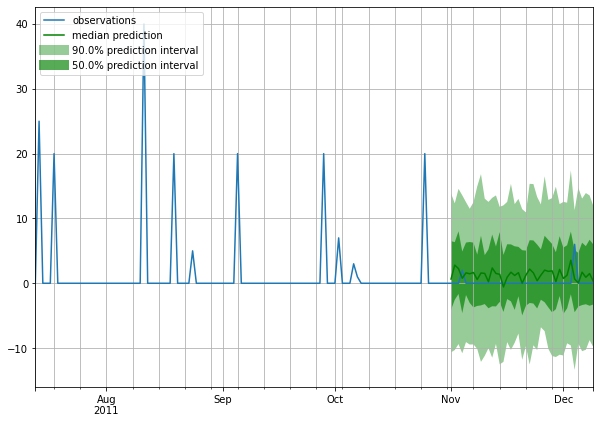

In [40]:
plot_prob_forecasts(tss[0], ets_forecast[0])

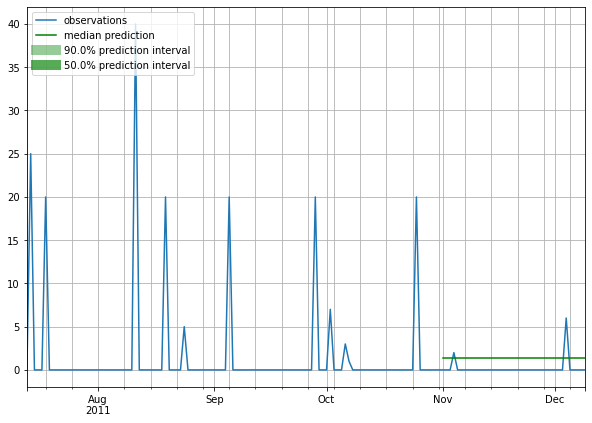

In [41]:
plot_prob_forecasts(tss[0], croston_forecast[0])

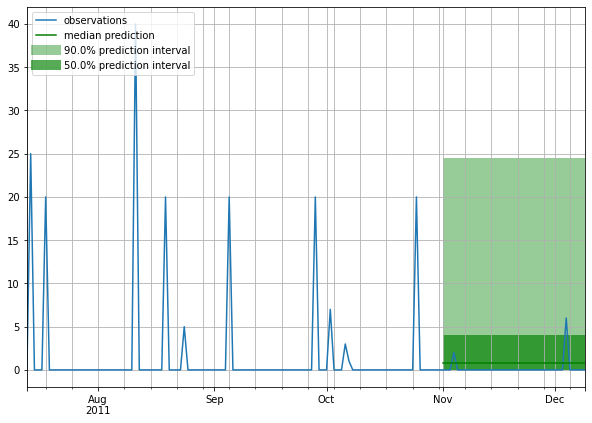

In [18]:
plot_prob_forecasts(tss[0], deep_renewal_flat_forecasts[0])

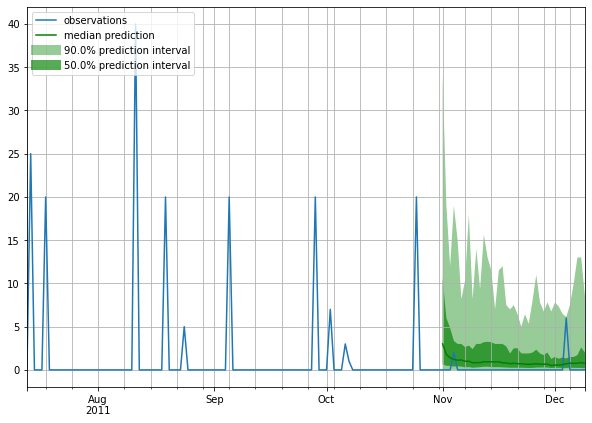

In [25]:
plot_prob_forecasts(tss[0], deep_renewal_hybrid_forecasts[0])

In [7]:
evaluator = IntermittentEvaluator(quantiles=[0.25,0.5,0.75], median=False, calculate_spec=True)
#DeepAR
deep_ar_agg_metrics, deep_ar_item_metrics = evaluator(
    iter(tss), iter(deep_ar_forecasts), num_series=len(test_ds)
)
#Croston
croston_agg_metrics, croston_item_metrics = evaluator(
    iter(tss), iter(croston_forecast), num_series=len(test_ds)
)
#SBA
sba_agg_metrics, sba_item_metrics = evaluator(
    iter(tss), iter(sba_forecast), num_series=len(test_ds)
)
#SBJ
sbj_agg_metrics, sbj_item_metrics = evaluator(
    iter(tss), iter(sbj_forecast), num_series=len(test_ds)
)
#NPTS
npts_agg_metrics, npts_item_metrics = evaluator(
    iter(tss), iter(npts_forecast), num_series=len(test_ds)
)
#ETS
ets_agg_metrics, ets_item_metrics = evaluator(
    iter(tss), iter(ets_forecast), num_series=len(test_ds)
)
#Arima
arima_agg_metrics, arima_item_metrics = evaluator(
    iter(tss), iter(arima_forecast), num_series=len(test_ds)
)
#DeepRenewal Flat
deep_renewal_flat_agg_metrics, deep_renewal_flat_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_flat_forecasts), num_series=len(test_ds)
)
#Deep Renewal Exact
deep_renewal_exact_agg_metrics, deep_renewal_exact_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_exact_forecasts), num_series=len(test_ds)
)
#Deep Renewal Hybrid
deep_renewal_hybrid_agg_metrics, deep_renewal_hybrid_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_hybrid_forecasts), num_series=len(test_ds)
)

Running evaluation:   0%|                                                                     | 0/1822 [00:00<?, ?it/s]D:\Playground\ts_research\deep_renewal\deeprenewal\deeprenewal\_evaluator.py:226: RuntimeWarning:

divide by zero encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\deeprenewal\_evaluator.py:267: RuntimeWarning:

divide by zero encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\deeprenewal\_evaluator.py:269: RuntimeWarning:

divide by zero encountered in double_scalars

Running evaluation: 100%|██████████████████████████████████████████████████████████| 1822/1822 [11:22<00:00,  2.67it/s]
D:\miniconda3\envs\timeseries\lib\site-packages\pandas\core\dtypes\cast.py:1507: UserWarning:


Running evaluation: 100%|██████████████████████████████████████████████████████████| 1822/1822 [13:17<00:00,  2.28it/s]


In [8]:
deep_ar_agg_metrics['method'] = "DeepAR"
croston_agg_metrics['method'] = "Croston"
sba_agg_metrics['method'] = "SBA"
sbj_agg_metrics['method'] = "SBJ"
npts_agg_metrics['method'] = "NPTS"
arima_agg_metrics['method'] = "ARIMA"
ets_agg_metrics['method'] = "ETS"
deep_renewal_flat_agg_metrics['method'] = "DeepRenewal Flat"
deep_renewal_exact_agg_metrics['method'] = "DeepRenewal Exact"
deep_renewal_hybrid_agg_metrics['method'] = "DeepRenewal Hybrid"

In [9]:
pd.set_option('display.max_columns', 500)

In [12]:
import joblib

In [10]:
joblib.dump([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics], "metrics.pkl")

['metrics.pkl']

In [13]:
[deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics] = joblib.load("metrics.pkl")

In [11]:
result_df = pd.DataFrame([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics])
result_df

MSE        MAE      MRAE      MASE      MAPE     MAAPE     sMAPE  \
0  1490.849999   9.420458  1.074516  1.075122  0.626764  0.635660  1.481585   
1  1621.297347  11.144141  0.896252  1.400758  0.649216  0.634243  1.510919   
2  1641.804053  10.921846  0.878738  1.350970  0.611183  0.635039  1.523079   
3  1650.164291  10.973551  0.906613  1.375619  0.624611  0.637081  1.525834   
4  1615.399359  11.007852  1.363292  1.978697  0.659389  0.620889  1.463612   
5  1539.857705  10.872118  1.375843  1.504312  0.726069  0.631198  1.442390   
6  1552.731912  11.037995  1.451053  1.489008  0.761983  0.636558  1.443175   
7  1765.649816  10.762739  1.108556  1.876113  0.407675  0.575241  1.468277   
8  1814.036492  10.747044  1.053536  1.615643  0.379744  0.571669  1.524852   
9  1804.839878  10.751055  1.060143  1.657459  0.379116  0.566264  1.509999   

   abs_target_sum  abs_target_mean      abs_error  seasonal_error        n  \
0        765651.0        10.775015  669398.893675      483.796926  71058.0   
1        765651.0        10.775015  791880.385754      483.796926  71058.0   
2        765651.0        10.775015  776084.551921      483.796926  71058.0   
3        765651.0        10.775015  779758.618797      483.796926  71058.0   
4        765651.0        10.775015  782195.980000      483.796926  71058.0   
5        765651.0        10.775015  772550.989331      483.796926  71058.0   
6        765651.0        10.775015  784337.868061      483.796926  71058.0   
7        765651.0        10.775015  764778.691734      483.796926  71058.0   
8        765651.0        10.775015  763663.430000      483.796926  71058.0   
9        765651.0        10.775015  763948.468568      483.796926  71058.0   

   non_zero_n            CFE           PIS  QuantileLoss[0.25]  \
0     35645.0  353075.532496 -6.737572e+06       378217.182178   
1     35645.0  253966.906978 -5.281551e+06       664896.932264   
2     35645.0  305492.901661 -6.312071e+06       623338.101090   
3     35645.0  303755.686801 -6.277327e+06       627880.775397   
4     35645.0  298776.040000 -6.184115e+06       380956.000000   
5     35645.0  203748.467974 -4.271325e+06       598779.297692   
6     35645.0  175114.249790 -3.817780e+06       622502.778932   
7     35645.0  520541.879826 -1.061305e+07       383524.400735   
8     35645.0  593821.710000 -1.176165e+07       382825.500000   
9     35645.0  581697.853391 -1.136008e+07       389981.225288   

   Coverage[0.25]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.75]  \
0        0.026063      679862.764344       0.204748        8.083363e+05   
1        0.633609      791880.385754       0.633609        9.188638e+05   
2        0.621914      776084.551921       0.621914        9.288310e+05   
3        0.621478      779758.618797       0.621478        9.316365e+05   
4        0.008162      725255.000000       0.096372        9.351025e+05   
5        0.076543      784662.741175       0.658448        9.579808e+05   
6        0.087830      796128.399976       0.658307        9.578084e+05   
7        0.061302      764167.863827       0.500141        1.047170e+06   
8        0.000000      765640.000000       0.000338        1.141210e+06   
9        0.489938      761474.496596       0.506628        1.069187e+06   

   Coverage[0.75]      NOSp     PBMAE    SPEC_0.75     SPEC_0.5   SPEC_0.25  \
0        0.542627  0.786955  0.480298   760.189618   530.966522  301.743426   
1        0.633609  0.776799  0.486011   989.515364   784.425965  579.336567   
2        0.621914  0.803170  0.486265  1046.830208   801.223057  555.615906   
3        0.621478  0.805386  0.486504  1056.139889   812.120456  568.101022   
4        0.388894  0.693898  0.542698   906.047343   672.325461  438.603580   
5        0.845858  0.666994  0.537195   605.722513   467.914070  330.105695   
6        0.846660  0.665535  0.542796   578.749135   458.416845  338.084575   
7        0.618607  0.795034  0.539855  1417.883747   979.874239  541.864732   
8        0.044344 

In [12]:
result_df.to_clipboard()

## Rounding

In [30]:
from tqdm.autonotebook import tqdm

In [31]:
def round_forecast(fc_l):
    for s in tqdm(fc_l):
        s.samples = np.round(s.samples)
    return fc_l

In [32]:
ets_forecast = round_forecast(forecast_dict['ets'])
arima_forecast = round_forecast(forecast_dict['arima'])
croston_forecast = round_forecast(forecast_dict['croston'])
sba_forecast = round_forecast(forecast_dict['sba'])
sbj_forecast = round_forecast(forecast_dict['sbj'])
npts_forecast = round_forecast(forecast_dict['npts'])
deep_ar_forecasts = round_forecast(forecast_dict['deep_ar'])
deep_renewal_flat_forecasts = round_forecast(forecast_dict['deep_renewal_flat'])
deep_renewal_exact_forecasts = round_forecast(forecast_dict['deep_renewal_exact'])
deep_renewal_hybrid_forecasts = round_forecast(forecast_dict['deep_renewal_hybrid'])

In [33]:
evaluator = IntermittentEvaluator(quantiles=[0.25,0.5,0.75], median=True, calculate_spec=False)
#DeepAR
deep_ar_agg_metrics, deep_ar_item_metrics = evaluator(
    iter(tss), iter(deep_ar_forecasts), num_series=len(test_ds)
)
#Croston
croston_agg_metrics, croston_item_metrics = evaluator(
    iter(tss), iter(croston_forecast), num_series=len(test_ds)
)
#SBA
sba_agg_metrics, sba_item_metrics = evaluator(
    iter(tss), iter(sba_forecast), num_series=len(test_ds)
)
#SBJ
sbj_agg_metrics, sbj_item_metrics = evaluator(
    iter(tss), iter(sbj_forecast), num_series=len(test_ds)
)
#NPTS
npts_agg_metrics, npts_item_metrics = evaluator(
    iter(tss), iter(npts_forecast), num_series=len(test_ds)
)
#ETS
ets_agg_metrics, ets_item_metrics = evaluator(
    iter(tss), iter(ets_forecast), num_series=len(test_ds)
)
#Arima
arima_agg_metrics, arima_item_metrics = evaluator(
    iter(tss), iter(arima_forecast), num_series=len(test_ds)
)
#DeepRenewal Flat
deep_renewal_flat_agg_metrics, deep_renewal_flat_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_flat_forecasts), num_series=len(test_ds)
)
#Deep Renewal Exact
deep_renewal_exact_agg_metrics, deep_renewal_exact_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_exact_forecasts), num_series=len(test_ds)
)
#Deep Renewal Hybrid
deep_renewal_hybrid_agg_metrics, deep_renewal_hybrid_item_metrics = evaluator(
    iter(tss), iter(deep_renewal_hybrid_forecasts), num_series=len(test_ds)
)

Running evaluation:   0%|                                                                     | 0/1822 [00:00<?, ?it/s]D:\Playground\ts_research\deep_renewal\deeprenewal\deeprenewal\_evaluator.py:226: RuntimeWarning:

divide by zero encountered in true_divide

D:\Playground\ts_research\deep_renewal\deeprenewal\deeprenewal\_evaluator.py:267: RuntimeWarning:

divide by zero encountered in double_scalars

D:\Playground\ts_research\deep_renewal\deeprenewal\deeprenewal\_evaluator.py:269: RuntimeWarning:

divide by zero encountered in double_scalars

Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:13<00:00, 132.10it/s]
D:\miniconda3\envs\timeseries\lib\site-packages\pandas\core\dtypes\cast.py:1507: UserWarning:


Running evaluation: 100%|█████████████████████████████████████████████████████████| 1822/1822 [00:13<00:00, 137.75it/s]


In [34]:
deep_ar_agg_metrics['method'] = "DeepAR"
croston_agg_metrics['method'] = "Croston"
sba_agg_metrics['method'] = "SBA"
sbj_agg_metrics['method'] = "SBJ"
npts_agg_metrics['method'] = "NPTS"
arima_agg_metrics['method'] = "ARIMA"
ets_agg_metrics['method'] = "ETS"
deep_renewal_flat_agg_metrics['method'] = "DeepRenewal Flat"
deep_renewal_exact_agg_metrics['method'] = "DeepRenewal Exact"
deep_renewal_hybrid_agg_metrics['method'] = "DeepRenewal Hybrid"

In [18]:
joblib.dump([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics], "metrics_median_round.pkl")

['metrics_median.pkl']

In [35]:
result_df = pd.DataFrame([deep_ar_agg_metrics,
                          croston_agg_metrics,
             sba_agg_metrics,
             sbj_agg_metrics,
             npts_agg_metrics,
                          arima_agg_metrics, 
                          ets_agg_metrics, 
                          deep_renewal_flat_agg_metrics, 
                          deep_renewal_exact_agg_metrics,
                          deep_renewal_hybrid_agg_metrics])
result_df

MSE        MAE      MRAE      MASE      MAPE     MAAPE     sMAPE  \
0  1634.492122   9.567716  0.978786  0.826500  0.498306  0.720567  1.748607   
1  1621.297347  11.144141  0.896252  1.400758  0.649216  0.634243  1.510919   
2  1641.804053  10.921846  0.878738  1.350970  0.611183  0.635039  1.523079   
3  1650.164291  10.973551  0.906613  1.375619  0.624611  0.637081  1.525834   
4  1770.325129  10.206521  1.026694  0.847358  0.487850  0.735898  0.967680   
5  1546.097092  11.042567  1.432415  1.582507  0.755394  0.638546  1.446139   
6  1555.780876  11.203924  1.509900  1.570936  0.791120  0.641798  1.445463   
7  1872.947108  10.754143  1.024593  1.127390  0.414845  0.659355  1.746132   
8  1888.273692  10.774860  1.088756  0.853233  0.501533  0.785269  1.003577   
9  1863.863828  10.716239  1.018837  1.131684  0.400059  0.640455  1.704317   

   abs_target_sum  abs_target_mean      abs_error  seasonal_error        n  \
0        765651.0        10.775015  679862.767623      483.796926  71058.0   
1        765651.0        10.775015  791880.385754      483.796926  71058.0   
2        765651.0        10.775015  776084.551921      483.796926  71058.0   
3        765651.0        10.775015  779758.618797      483.796926  71058.0   
4        765651.0        10.775015  725255.000000      483.796926  71058.0   
5        765651.0        10.775015  784662.741175      483.796926  71058.0   
6        765651.0        10.775015  796128.399976      483.796926  71058.0   
7        765651.0        10.775015  764167.863661      483.796926  71058.0   
8        765651.0        10.775015  765640.000000      483.796926  71058.0   
9        765651.0        10.775015  761474.496596      483.796926  71058.0   

   non_zero_n            CFE           PIS  QuantileLoss[0.25]  \
0     35645.0  598640.757209 -1.176243e+07       378217.182178   
1     35645.0  253966.906978 -5.281551e+06       664896.932264   
2     35645.0  305492.901661 -6.312071e+06       623338.101090   
3     35645.0  303755.686801 -6.277327e+06       627880.775397   
4     35645.0  654027.000000 -1.328676e+07       380956.000000   
5     35645.0  187302.036334 -3.936624e+06       598779.297692   
6     35645.0  157892.853213 -3.480166e+06       622502.778932   
7     35645.0  721768.654759 -1.463759e+07       383524.400735   
8     35645.0  765570.000000 -1.551207e+07       382825.500000   
9     35645.0  707211.713078 -1.416596e+07       389981.225288   

   Coverage[0.25]  QuantileLoss[0.5]  Coverage[0.5]  QuantileLoss[0.75]  \
0        0.026063      679862.764344       0.204748        8.083363e+05   
1        0.633609      791880.385754       0.633609        9.188638e+05   
2        0.621914      776084.551921       0.621914        9.288310e+05   
3        0.621478      779758.618797       0.621478        9.316365e+05   
4        0.008162      725255.000000       0.096372        9.351025e+05   
5        0.076543      784662.741175       0.658448        9.579808e+05   
6        0.087830      796128.399976       0.658307        9.578084e+05   
7        0.061302      764167.863827       0.500141        1.047170e+06   
8        0.000000      765640.000000       0.000338        1.141210e+06   
9        0.489938      761474.496596       0.506628        1.069187e+06   

   Coverage[0.75]      NOSp     PBMAE       RMSE       CFE_min        CFE_max  \
0        0.542627  0.972787  0.538856  40.428853   7130.972656  598640.812500   
1        0.633609  0.776799  0.486011  40.265337    536.895051  258280.011928   
2        0.621914  0.803170  0.486265  40.519181   1858.074402  308484.827259   
3        0.621478  0.805386  0.486504  40.622214   1813.530431  306792.156370   
4        0.388894  0.977248  0.266290  42.075232  10599.000000  654027.000000   
5        0.845858  0.647328  0.544091  39.320441  -1380.116632  193531.179485   
6        0.846660  0.648394  0.548003  39.443388  -1302.584725  164780.614826   
7        0.618607  0.964511  0.502857  43.277559  12531.821289  721768.500000   


In [36]:
result_df.to_clipboard()

In [44]:
import plotly.express as px

In [44]:
result_df = result_df[['method','MSE', 'MASE', 'MAPE', 'sMAPE', 'MSIS',
       'QuantileLoss[0.25]', 'Coverage[0.25]', 'QuantileLoss[0.5]',
       'Coverage[0.5]', 'QuantileLoss[0.75]', 'Coverage[0.75]', 'RMSE',
       'NRMSE', 'ND', 'wQuantileLoss[0.25]', 'wQuantileLoss[0.5]',
       'wQuantileLoss[0.75]', 'mean_wQuantileLoss', 'MAE_Coverage']]

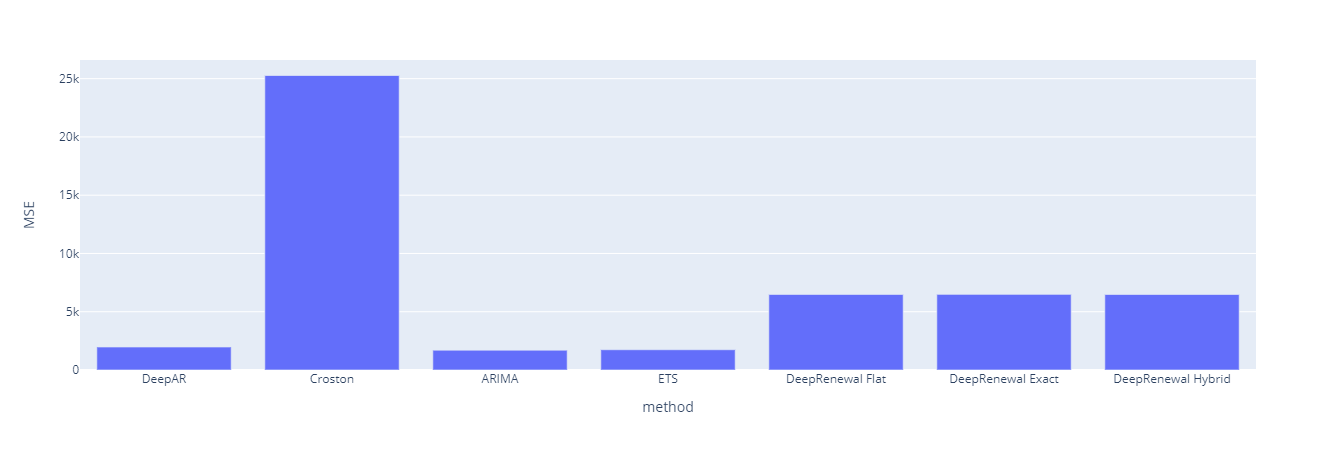

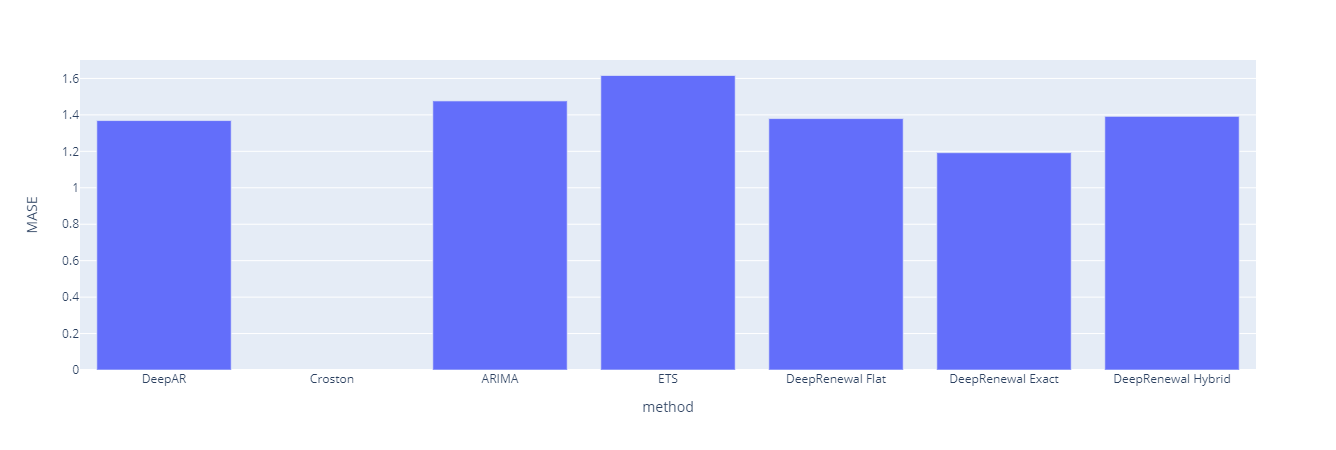

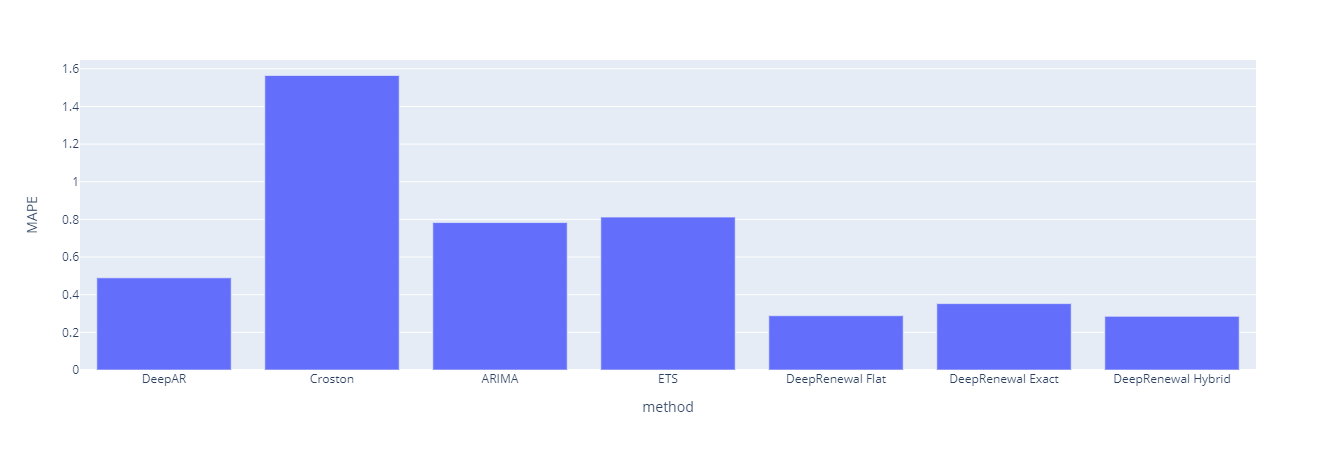

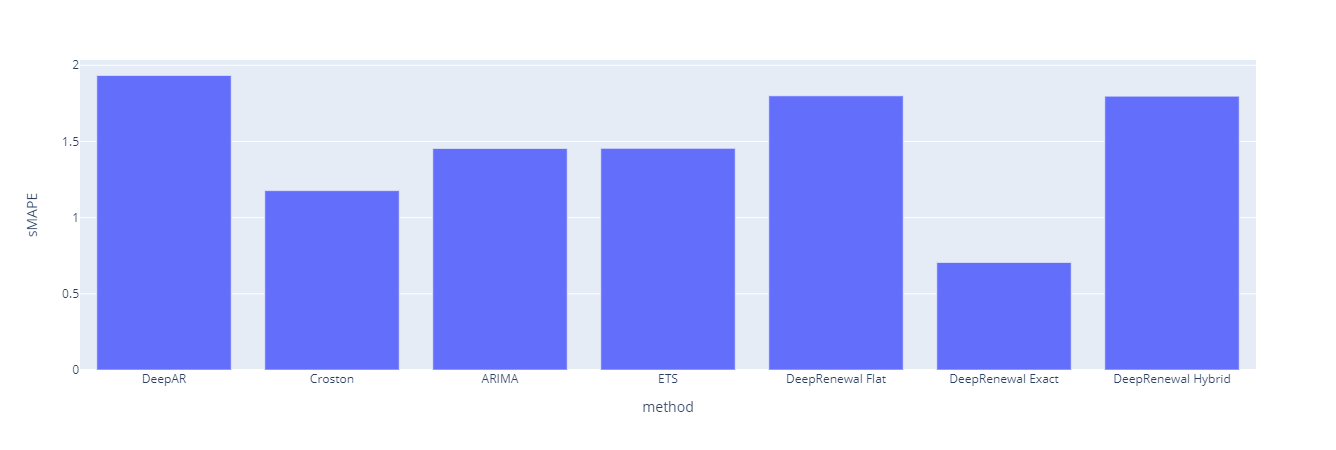

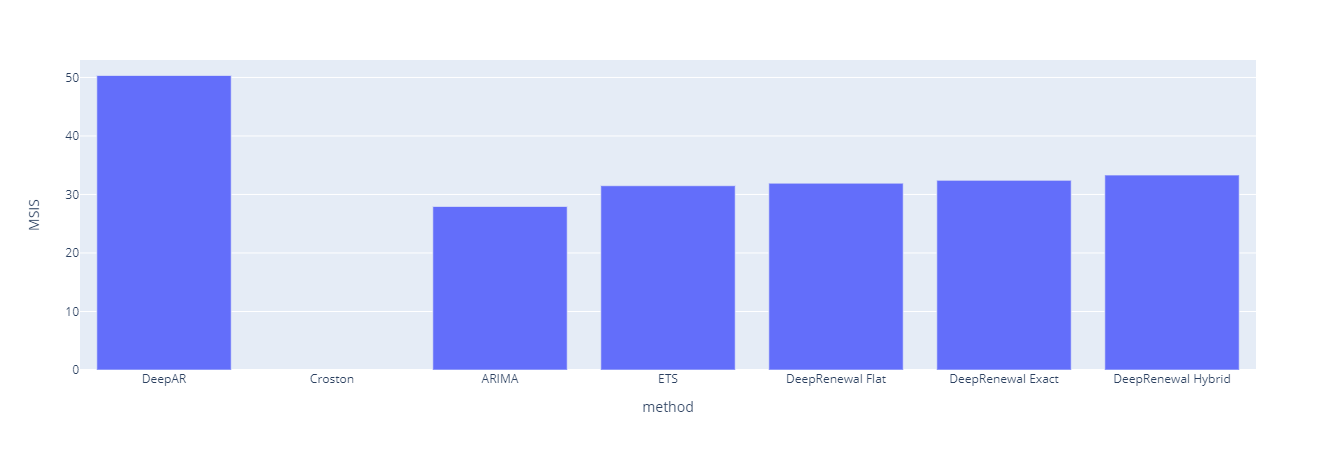

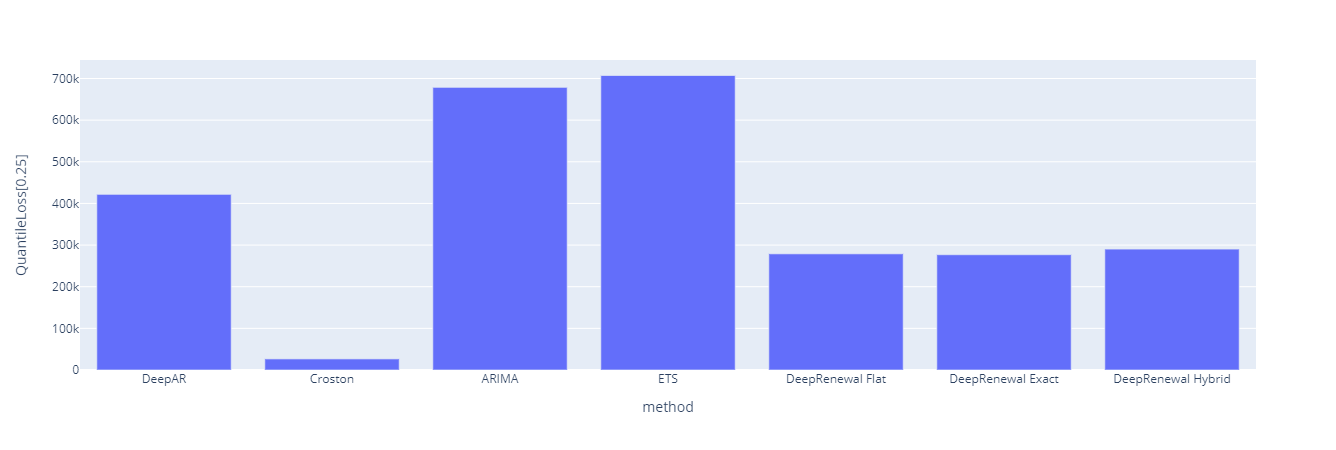

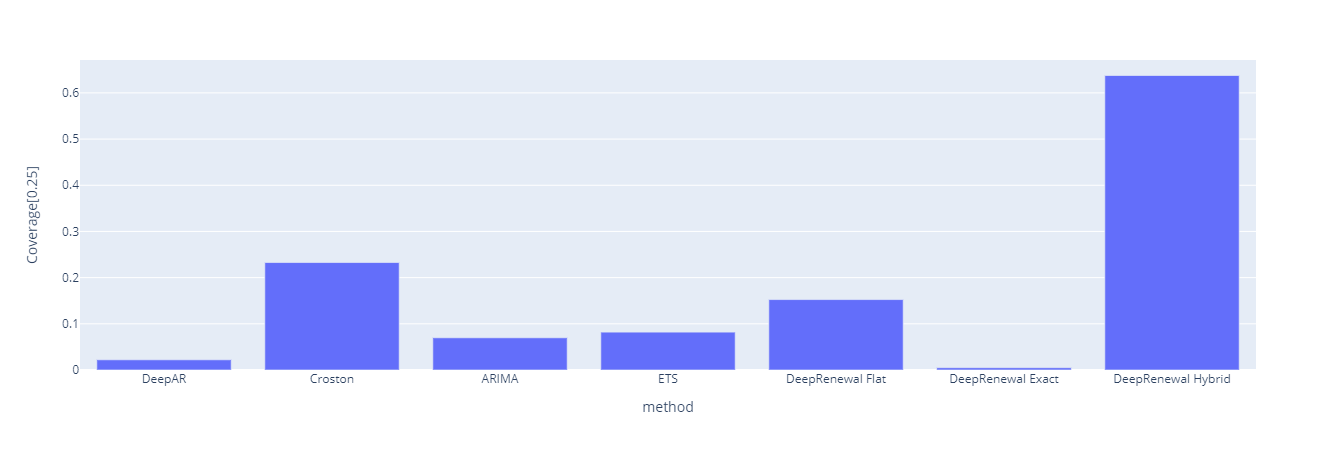

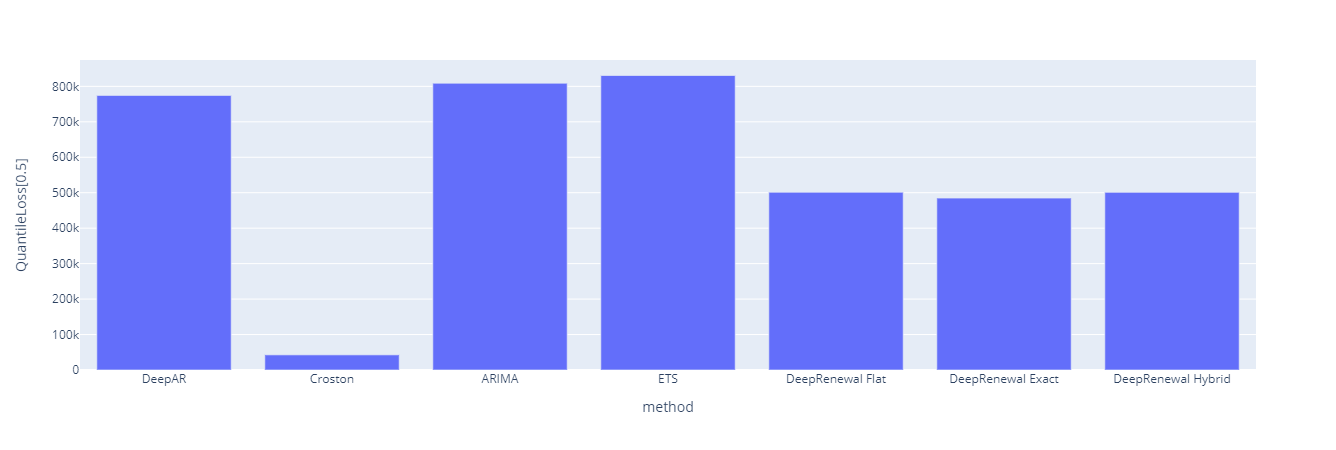

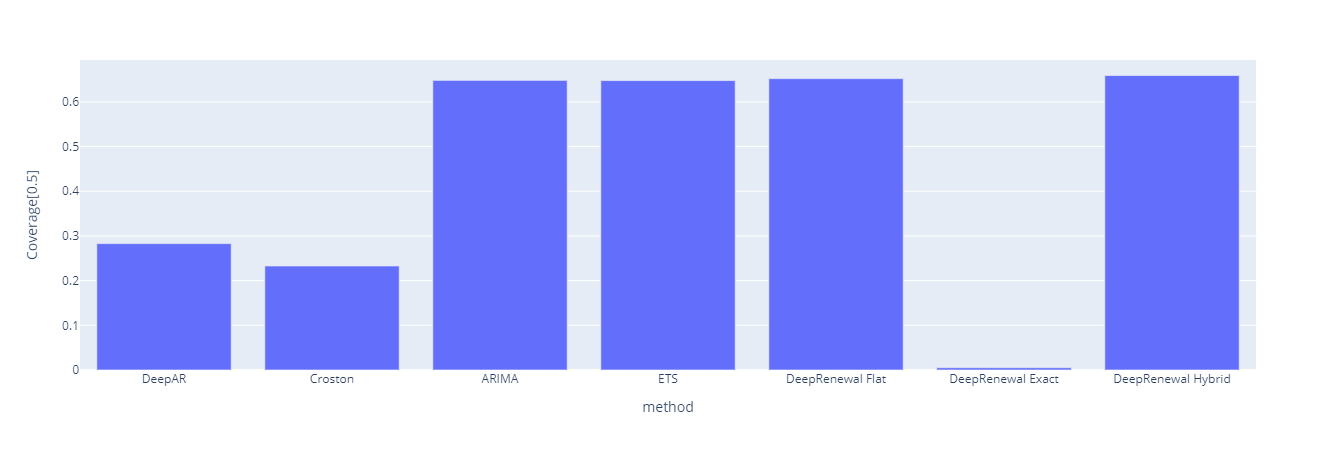

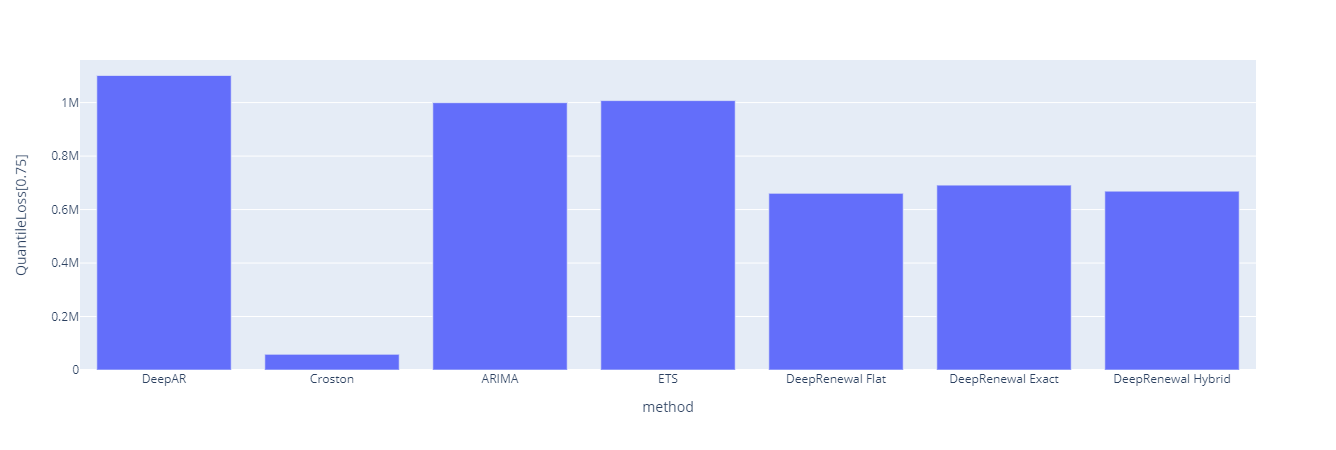

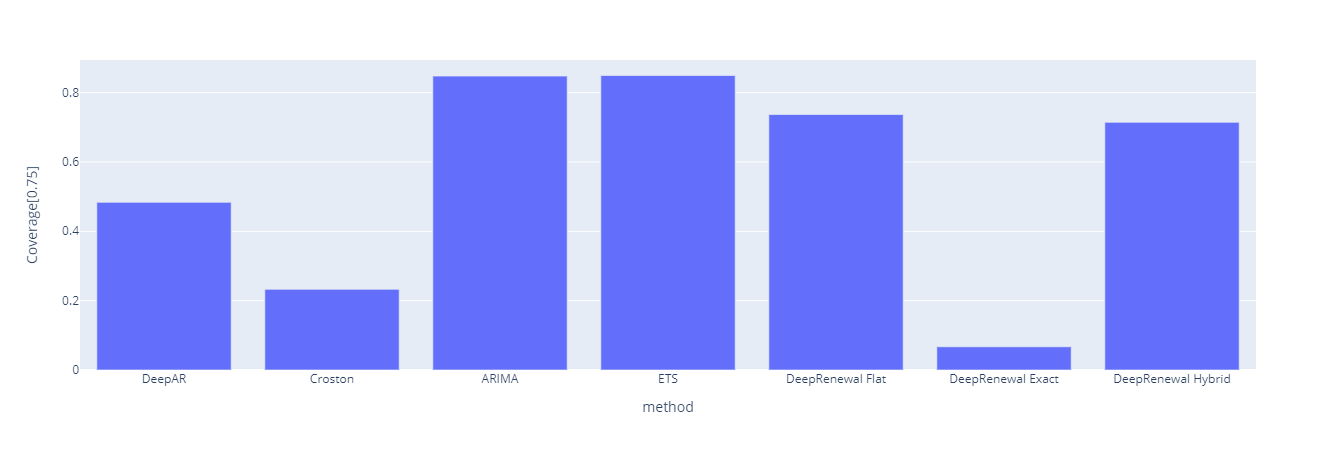

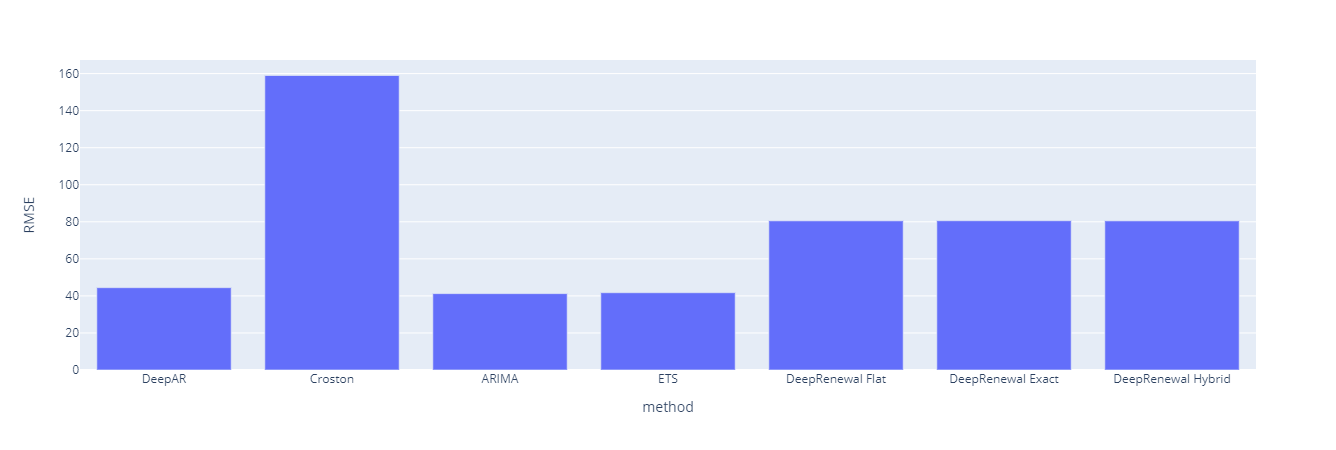

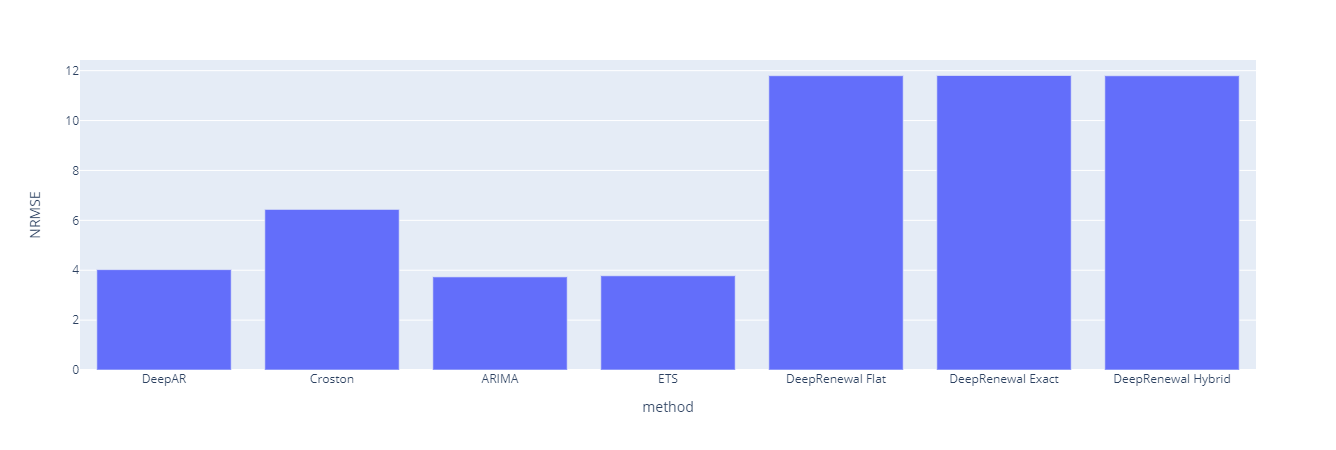

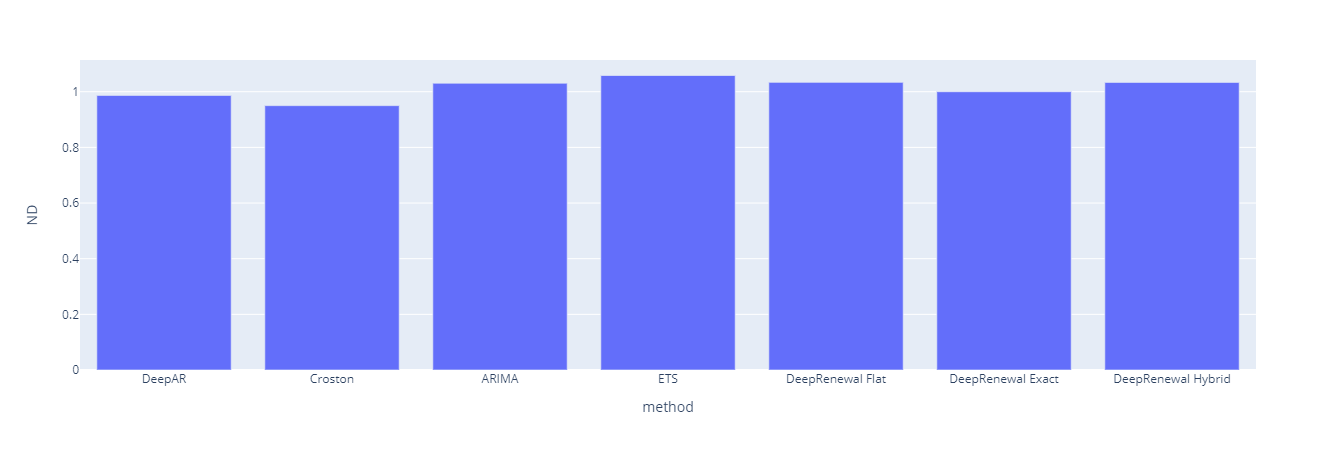

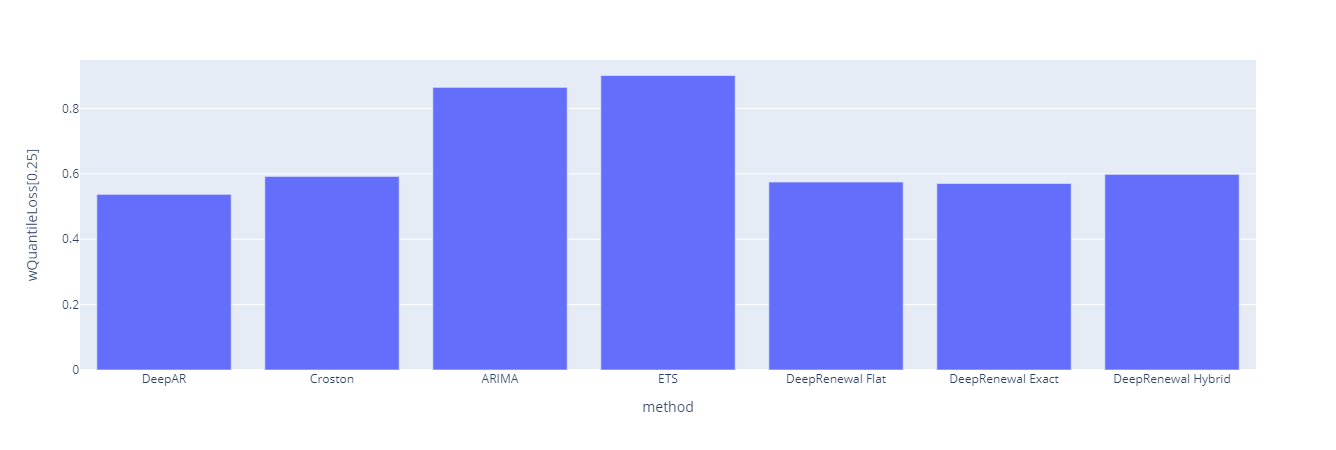

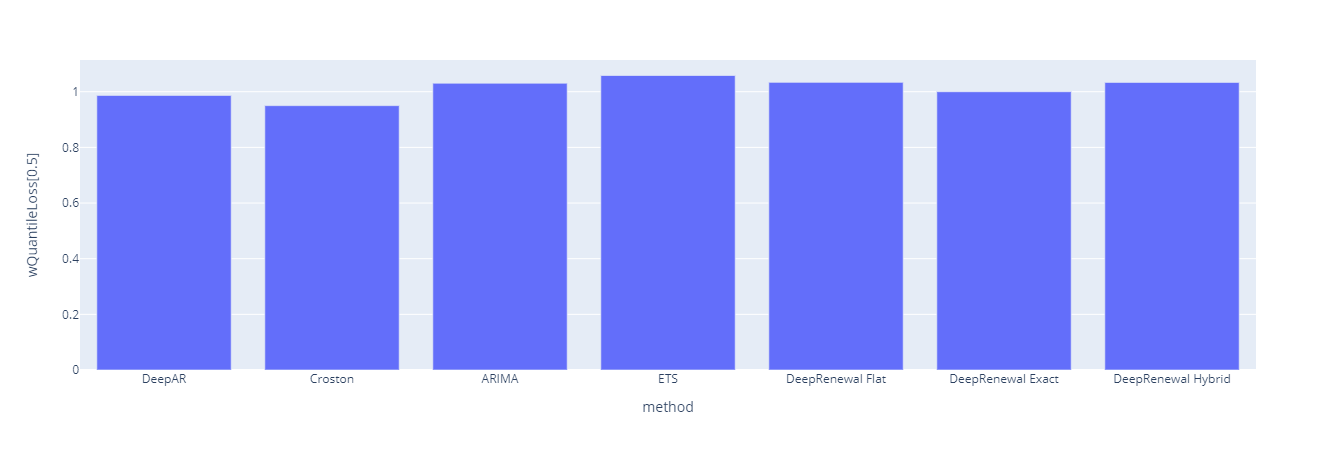

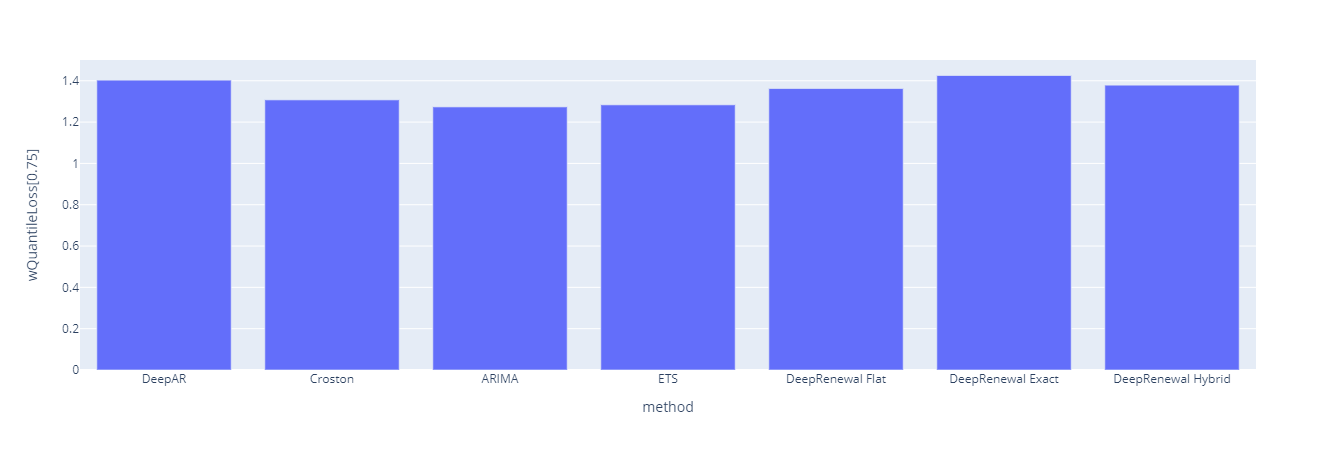

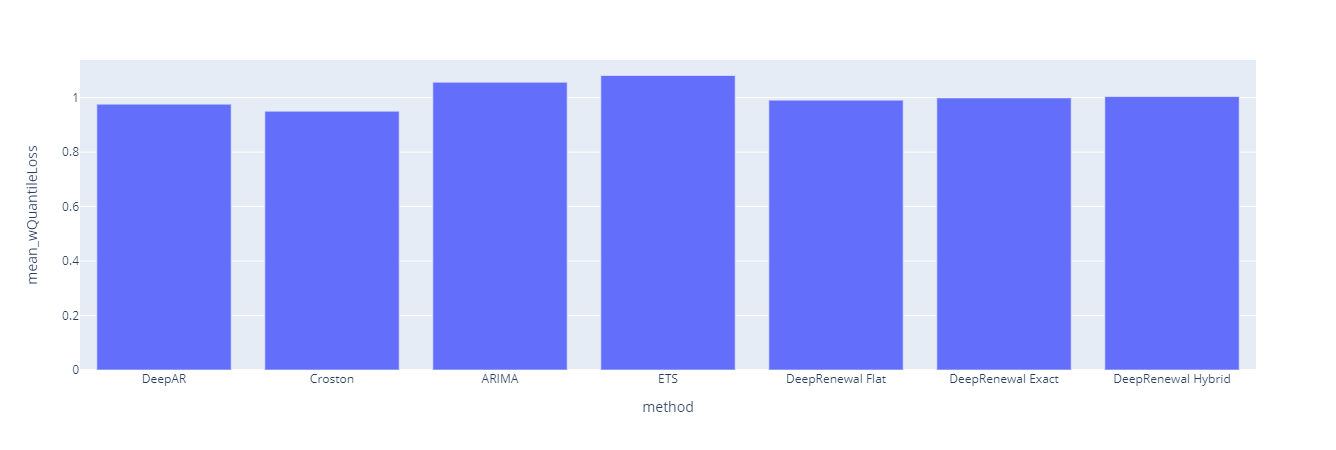

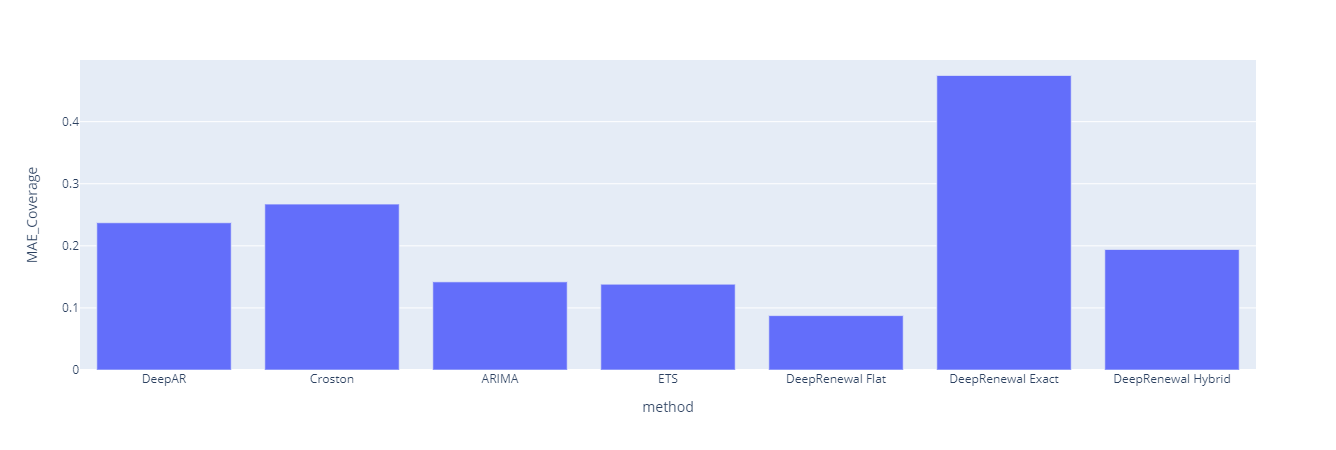

In [45]:
for metric in ['MSE', 'MASE', 'MAPE', 'sMAPE', 'MSIS',
       'QuantileLoss[0.25]', 'Coverage[0.25]', 'QuantileLoss[0.5]',
       'Coverage[0.5]', 'QuantileLoss[0.75]', 'Coverage[0.75]', 'RMSE',
       'NRMSE', 'ND', 'wQuantileLoss[0.25]', 'wQuantileLoss[0.5]',
       'wQuantileLoss[0.75]', 'mean_wQuantileLoss', 'MAE_Coverage']:
    fig = px.bar(result_df[['method',metric]], x="method", y=metric)
    fig.show()

In [31]:
# _max = result_df.max(axis=0)
# _result = result_df.copy()
# for col in result_df.columns:
#     if col != "method":
#         _result[col] = _result[col]/_max[col]
        

In [42]:
plot_df = pd.melt(result_df,id_vars = "method", var_name="Metric")
plot_df.head()

method Metric        value
0   DeepAR    MSE  1634.492122
1  Croston    MSE  1621.297347
2      SBA    MSE  1641.804053
3      SBJ    MSE  1650.164291
4     NPTS    MSE  1770.325129

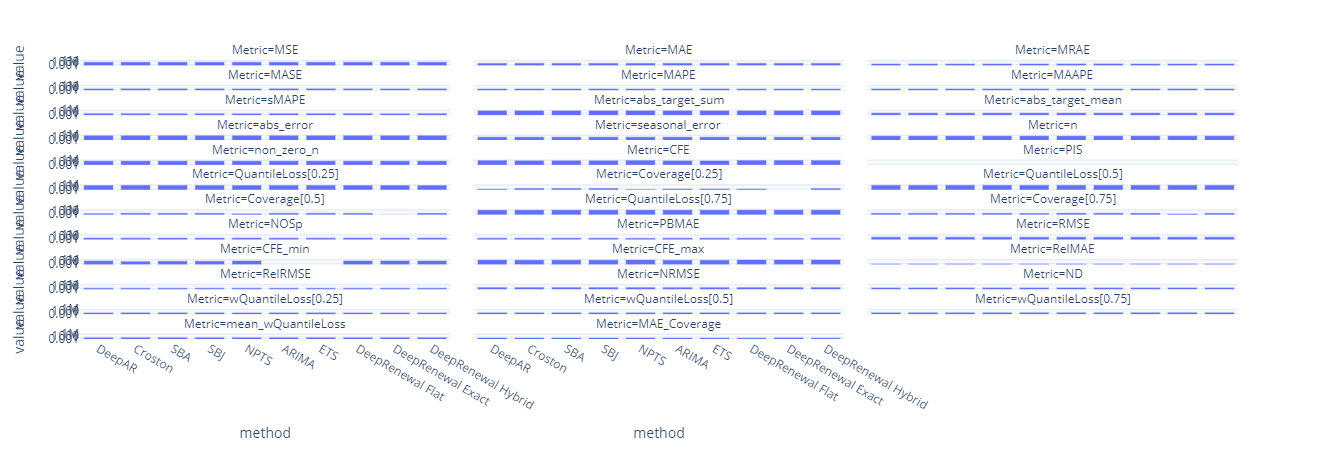

In [45]:
px.bar(plot_df, x="method", y="value", facet_col="Metric", facet_col_wrap=3, log_y=True)